# SKLearn-API

In this notebook we demonstrate the high-level API that we provide in GPJax that is designed to be similar to the API of [scikit-learn](https://scikit-learn.org/stable/).

In [1]:
from jax.config import config

config.update("jax_enable_x64", True)

import jax.random as jr
import jax.numpy as jnp
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx


key = jr.PRNGKey(123)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

## Dataset

With the necessary modules imported, we simulate a dataset
$\mathcal{D} = (\boldsymbol{x}, \boldsymbol{y}) = \{(x_i, y_i)\}_{i=1}^{100}$ with inputs $\boldsymbol{x}$
sampled uniformly on $(-3., 3)$ and corresponding independent noisy outputs

$$\boldsymbol{y} \sim \mathcal{N} \left(\sin(4\boldsymbol{x}) + \cos(2 \boldsymbol{x}), \textbf{I} * 0.3^2 \right).$$

We store our data $\mathcal{D}$ as a GPJax `Dataset` and create test inputs and labels
for later.

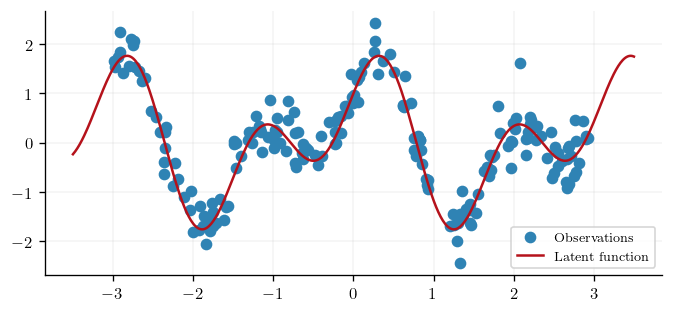

In [2]:
key = jr.PRNGKey(123)

# Simulate data
n = 200
noise = 0.3
key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)


fig, ax = plt.subplots()
ax.plot(x, y, "o", label="Observations", color=cols[0])
ax.plot(xtest, ytest, label="Latent function", color=cols[1])
ax.legend(loc="best")

## Model building

We'll now proceed to build our model. Within the SKLearn API we have three main classes: `GPJaxRegressor`, `GPJaxClassifier`, and `GPJaxOptimizer`/`GPJaxOptimiser`. We'll consider a problem where the response is continuous and so we'll use the `GPJaxRegressor` class. The problem is identical to the one considered in the [Regression notebook](regression.py); however, we'll now use the SKLearn API to build our model. This offers an alternative to the lower-level API and is designed to be similar to the API of [scikit-learn](https://scikit-learn.org/stable/).

In [3]:
model = gpx.sklearn.GPJaxRegressor(kernel=gpx.kernels.RBF())

2023-11-05 19:50:52.739 | INFO     | gpjax.sklearn.base:__post_init__:46 - No mean function specified, using constant mean function
2023-11-05 19:50:52.741 | INFO     | gpjax.sklearn.base:__post_init__:48 - Building GP prior with RBF kernel


Let's now fit the model. Using the abstraction provided by `GPJaxRegressor`, this can be achieved by simply invoking the `fit` method. 

In [4]:
model.fit(x, y, key=key)

2023-11-05 19:50:52.789 | INFO     | gpjax.sklearn.regression:fit:40 - 200 training data points supplied.
2023-11-05 19:50:52.790 | INFO     | gpjax.sklearn.base:_get_objective_and_model_for_small_data:126 - Conjugate likelihood identified
2023-11-05 19:50:52.790 | INFO     | gpjax.sklearn.base:_get_objective_and_model_for_small_data:128 - Using conjugate marginal log likelihood
2023-11-05 19:50:52.790 | INFO     | gpjax.sklearn.regression:fit:46 - Compiling objective function
2023-11-05 19:50:52.791 | INFO     | gpjax.sklearn.regression:fit:50 - No optimizer specified.
2023-11-05 19:50:52.791 | INFO     | gpjax.sklearn.regression:fit:51 - Using Adam optimizer with learning rate 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

2023-11-05 19:50:54.766 | INFO     | gpjax.sklearn.regression:fit:62 - Starting loss:  240.953
2023-11-05 19:50:54.781 | INFO     | gpjax.sklearn.regression:fit:63 - Final loss:  109.046


In the above cell, the Adam optimiser was used as the the default optimiser. However, should you wish to use another optimiser from [Optax](https://github.com/google-deepmind/optax), then you can simply supply it to fit as follows
```
import optax as ox

model.fit(x, y, key=key, optim = ox.sgd(learning_rate=0.01))
```

## Model evaluation

With a model now fit, we wish to evaluate the model's quality. To do this, we can _score_ the model using either a GPJax scoring function, or a [metric from sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html). We demonstrate how this can be achieved using GPJax's log-posterior density, and the mean-squared error function from sklearn. Scoring functions can be evaluation on either the training or test set, as we show below.

In [5]:
from sklearn.metrics import mean_squared_error

model.score(xtest, ytest, gpx.sklearn.SKLearnScore('mse', mean_squared_error))
model.score(x, y, gpx.sklearn.LogPredictiveDensity())

2023-11-05 19:50:54.977 | INFO     | gpjax.sklearn.regression:predict:67 - Predicting 500 test data points
2023-11-05 19:50:56.384 | INFO     | gpjax.sklearn.base:score:89 - mse:  0.062
2023-11-05 19:50:56.385 | INFO     | gpjax.sklearn.regression:predict:67 - Predicting 200 test data points
2023-11-05 19:50:57.424 | INFO     | gpjax.sklearn.base:score:89 - Log-posterior density: -452.081


Array(-452.0808856, dtype=float64)

## Model prediction

Once we're happy with the model's performance, we can make predictions using the `predict` method. Here we are presented with four options:
1. `predict` returns the predictive posterior distribution
2. `predict_mean` returns the expected value of the predictive posterior distribution
3. `predict_stddev` returns the standard-deviation of the predictive posterior distribution
4. `predict_mean_and_stddev` returns 2. and 3.

2023-11-05 19:52:36.329 | INFO     | gpjax.sklearn.regression:predict:67 - Predicting 500 test data points


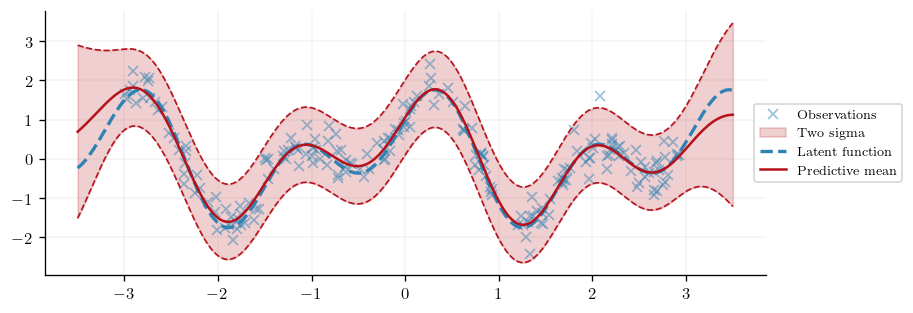

In [8]:
mu, sigma = model.predict_mean_and_stddev(xtest)

fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    xtest.squeeze(),
    mu - 2 * sigma,
    mu + 2 * sigma,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest,
    mu - 2 * sigma,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest,
    mu + 2 * sigma,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(xtest, mu, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))


## System configuration

In [7]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Thomas Pinder'

Author: Thomas Pinder

Last updated: Sun Nov 05 2023

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.16.1

jax       : 0.4.18
matplotlib: 3.8.0
gpjax     : 0.7.1

Watermark: 2.4.3

